# Truncated Power Series and Differential Algebra applied...

The present document demonstrates how "Truncated Power Series" and "Differential Algebra" techniques can help to check particle tracking codes for symplecticity. 

$-$ Adrian Oeftiger, January 2018

In [1]:
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# comment this if you don't want to plot with the seaborn library
import seaborn as sns

sns.set_context('talk', font_scale=1.4, rc={'lines.linewidth': 3})
sns.set_style('whitegrid', {'grid.linestyle': ':', 'axes.edgecolor': '0.5', 
                            'axes.linewidth': 1.2, 'legend.frameon': True})

In [3]:
import libTPSA
# see also libsymple.py

Example for 2D phase space in $x$ and $p_x$: the first entry in the series is 0-order, the second entry is the differential $dx$ and the third is $dp_x$:

In [4]:
# position at 2, infinitesimal dx
x = libTPSA.TPS([2, 1, 0])
# momentum at 0, infinitesimal dp_x
xp = libTPSA.TPS([0, 0, 1])

The initial differentials make up a unit Jacobian:

In [5]:
jacobian = [x.diff, xp.diff]
pprint (jacobian, width=10)
print ("\nJacobian determinant: {}".format(
    np.linalg.det(jacobian)))

[(1, 0),
 (0, 1)]

Jacobian determinant: 1.0


Take the harmonic oscillator as a simple example, e.g. $\mathcal{H}=\frac{1}{2}\left(p_x^2 + x^2\right)$ such that the equations of motion are simply
$$\partial \mathcal{H} / \partial p_x = p_x$$ and $$\partial \mathcal{H} / \partial x = x.$$

In [6]:
def H_p(xp): return xp # momentum derivative
def H_x(x): return x  # spatial derivative

# Symplectic Example

Let's integrate these equations of motion with some symplectic leap frogging:

In [7]:
timestep = 0.01

for step in range(42):
    xp = xp - H_x(x)  * timestep / 2.
    x  = x  + H_p(xp) * timestep
    xp = xp - H_x(x)  * timestep / 2.

By now, the tracking has changed the numbers (0-order of the TPS) as expected:

In [8]:
x.real, xp.real

(1.8261764534441789, -0.81551390785014755)

The Jacobian matrix entries changed along the tracking as well. As we started with a unit Jacobian matrix, we can now see what the tracking did in terms of the differential flow: let's check the Jacobian determinant...

In [9]:
jacobian = [x.diff, xp.diff]
pprint (jacobian, width=10)
print ("\nJacobian determinant: {}".format(
    np.linalg.det(jacobian)))

[(0.91308822672208945,
  0.40776714810377629),
 (-0.40775695392507377,
  0.91308822672208845)]

Jacobian determinant: 1.0


Voila, our leap frogging is indeed symplectic. The Jacobian determinant wasn't changed and remained unity, i.e. phase space volume is preserved during the tracking.

During the tracking we can even plot the 0-order of the TPS to see our harmonic oscillator:

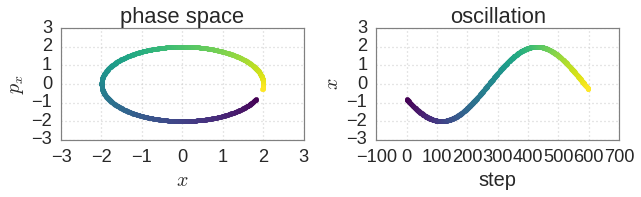

In [10]:
n_steps = 600
timestep = 0.01

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.3)
ax1.set_title('phase space')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$p_x$')
ax2.set_title('oscillation')
ax2.set_xlabel('step')
ax2.set_ylabel('$x$')

cm = plt.get_cmap('viridis')
cgen = (cm(float(i) / (n_steps - 1)) for i in range(n_steps))

for step in range(n_steps):
    xp = xp - H_x(x)  * timestep / 2.
    x  = x  + H_p(xp) * timestep
    xp = xp - H_x(x)  * timestep / 2.
    
    color = next(cgen)
    ax1.scatter(x.real, xp.real, color=color)
    ax2.scatter(step, xp.real, color=color)

# Non-symplectic Example

This time we will do 2nd order Runge-Kutta showing that it is not symplectic. We start from the same set up:

In [11]:
# position at 2, infinitesimal dx
x = libTPSA.TPS([2, 1, 0])
# momentum at 0, infinitesimal dp_x
xp = libTPSA.TPS([0, 0, 1])

The Runge-Kutta tracking:

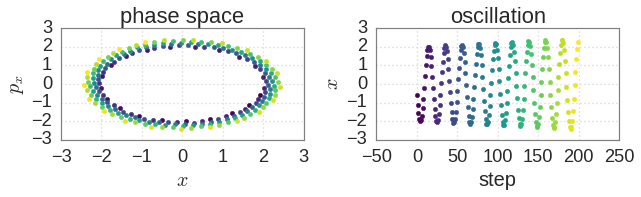

In [12]:
n_steps = 200
timestep = 0.3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.3)
ax1.set_title('phase space')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$p_x$')
ax2.set_title('oscillation')
ax2.set_xlabel('step')
ax2.set_ylabel('$x$')

cm = plt.get_cmap('viridis')
cgen = (cm(float(i) / (n_steps - 1)) for i in range(n_steps))

for step in range(n_steps):
    x_1  = timestep * H_p(xp)
    xp_1 = -timestep * H_x(x)
    x_2  = timestep * H_p(xp + 0.5*xp_1)
    xp_2 = -timestep * H_x(x + 0.5*x_1)
    
    x  = x  + x_2
    xp = xp + xp_2
    
    color = next(cgen)
    ax1.scatter(x.real, xp.real, color=color)
    ax2.scatter(step, xp.real, color=color)

Clearly the energy of the oscillator grows over time due to the non-symplecticity of the integration method. Let's check the Jacobian to verify this:

In [13]:
jacobian = [x.diff, xp.diff]
pprint (jacobian, width=10)
print ("\nJacobian determinant: {}".format(
    np.linalg.det(jacobian)))

[(-0.46102158829335288,
  -1.1340845391251824),
 (1.1340845391251824,
  -0.46102158829335288)]

Jacobian determinant: 1.49868864676


Of course a time step this large showed the non-symplecticity much clearlier. However, even if we stick to the small time step from the symplectic example, we will note the Jacobian determinant to depart from unity although the artificial heating is not visible by eye:

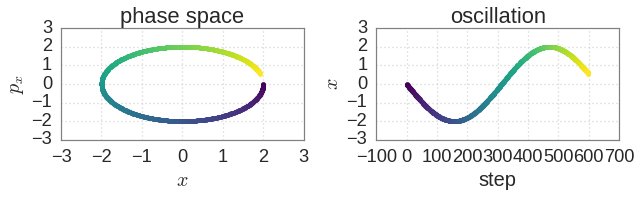

In [14]:
# position at 2, infinitesimal dx
x = libTPSA.TPS([2, 1, 0])
# momentum at 0, infinitesimal dp_x
xp = libTPSA.TPS([0, 0, 1])

n_steps = 600
timestep = 0.01

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.3)
ax1.set_title('phase space')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$p_x$')
ax2.set_title('oscillation')
ax2.set_xlabel('step')
ax2.set_ylabel('$x$')

cm = plt.get_cmap('viridis')
cgen = (cm(float(i) / (n_steps - 1)) for i in range(n_steps))

for step in range(n_steps):
    x_1  = timestep * H_p(xp)
    xp_1 = -timestep * H_x(x)
    x_2  = timestep * H_p(xp + 0.5*xp_1)
    xp_2 = -timestep * H_x(x + 0.5*x_1)
    
    x  = x  + x_2
    xp = xp + xp_2
    
    color = next(cgen)
    ax1.scatter(x.real, xp.real, color=color)
    ax2.scatter(step, xp.real, color=color)

In [15]:
jacobian = [x.diff, xp.diff]
pprint (jacobian, width=10)
print ("\nJacobian determinant: {}".format(
    np.linalg.det(jacobian)))

[(0.96019894271023742,
  -0.27931969214373153),
 (0.27931969214373153,
  0.96019894271023742)]

Jacobian determinant: 1.0000015


$\implies$ We departed from the symplectic integration case by a factor $1.5\times 10^{-6}$.

# Conclusion

Differential algebra can be very useful to check blackbox codes for symplecticity. The Jacobian matrix can be extracted from the truncated power series in order to check the symplectic condition.

In order to implement functions such as $\exp,\sin,\cos,...$ to work with truncated power series things become a bit more involved. A possible approach is context-sensitive function dispatch (redirecting to e.g. `np.sin` or instead to a particular implementation of a differential TPSA $\sin$) depending on what object (a simple number or a TPS) is passed. 

More advanced implementations of differential algebra techniques can be found e.g. in
- Cosy Infinity (http://www.cosyinfinity.org/)
- Polymorphic Tracking Code (http://mad.web.cern.ch/mad/)
- MAD NG (https://github.com/MethodicalAcceleratorDesign/MAD under `src/*tpsa*`)